In [1]:
#Another Run

In [2]:
#Import necessary stuff

In [ ]:
!pip install keras-tqdm
!pip install import-ipynb

In [42]:
import os
import numpy as np 
import glob 
from keras_tqdm import TQDMNotebookCallback
from os.path import join as pJoin
import random
from keras.applications import vgg19
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
import ssl
import h5py
from sklearn.model_selection import train_test_split
import import_ipynb
import utils

In [14]:
#Maybe fix following because of security issues

In [15]:
ssl._create_default_https_context = ssl._create_unverified_context

In [16]:
###########################DATA CLEANING########################
# Create Dictionary of Paths and Categories, remove from dictionary,
#     remove from dictionary those paths which are empty

In [17]:
#Create dictionary of category label for each image path
cat_d = {}
with open('/floyd/input/deep_fashion_images/Anno/list_category_img.txt') as f:
    for line in f:
        line = line.split(" ")
        key = line[0]
        val = line[-1].strip()
        cat_d[key] = (val)

In [18]:
#Create dictionary of test, train, val parition label for each path
train_d = {}
with open('/floyd/input/deep_fashion_images_partition/list_eval_partition.txt') as f:
    for line in f:
        line = line.split(" ")
        key =  line[0]
        val = line[-1].strip()
        if key in cat_d:
            train_d[key] = (val)

In [19]:
#Make sure path exists
for path in cat_d.keys():
    imgpath = pJoin('/floyd/input/deep_fashion_images', path)
    if os.path.exists(imgpath) == False:
        del cat_d[path]
        del train_d[path]

In [20]:
#Check, should be equal

In [21]:
print cat_d.keys() == train_d.keys()

True


In [22]:
#If True, DATA CLEANING FINISHED

In [33]:
#Create train, val, test batches

In [34]:
train_labels =[]
eval_labels=[]
test_labels=[]
for name in (cat_d.keys()):
	if partitionLookup(name) == ('train'):
		train_labels.append(name)
	elif partitionLookup(name) == ('val'):
		eval_labels.append(name)
	elif partitionLookup(name) == ('test'):
		test_labels.append(name)
train_labels = np.array([train_labels])
eval_labels = np.array([eval_labels])
test_labels = np.array([test_labels])

In [35]:
a= np.random.randint(0, len(train_labels[0]), 16)
floydDir = ('/floyd/input/deep_fashion_images/')
pathOrig = train_labels[0][a]
path = map(lambda pathName: floydDir + pathName, pathOrig)
# path = pJoin('/floyd/input/deep_fashion_images/', list(train_labels))
img_batch=[]
label_batch=[]

print len(train_labels)


1


In [36]:
#Create Batch Generator

In [24]:
def train_batch_generator(train_labels, batch_size=16):
    floydDir = ('/floyd/input/deep_fashion_images/')
    while True:
        # choose batch_size random images / labels from the data
        a= np.random.randint(0, len(train_labels[0]), 16)
        pathOrig = train_labels[0][a]
        path = map(lambda pathName: floydDir + pathName, pathOrig)
        img_batch=[]
        label_batch=[]
        for i, path in enumerate(path):
            img_batch.append(importImage(path))
            label_batch.append(catLookup(pathOrig[i]))
        yield np.array(img_batch), np.array(label_batch)

In [25]:
def val_batch_generator(eval_labels, batch_size=16):
    floydDir = ('/floyd/input/deep_fashion_images/')
    while True:
        # choose batch_size random images / labels from the data
        a= np.random.randint(0, len(eval_labels[0]), 16)
        pathOrig = eval_labels[0][a]
        path = map(lambda pathName: floydDir + pathName, pathOrig)
        img_batch=[]
        label_batch=[]
        for i, path in enumerate(path):
            img_batch.append(importImage(path))
            label_batch.append(catLookup(pathOrig[i]))
        yield np.array(img_batch), np.array(label_batch)

In [26]:
batch_size = 128
train_gen = train_batch_generator(train_labels, batch_size)
val_gen = val_batch_generator(eval_labels, batch_size)

In [27]:
#Import model
vgg_model = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#Make top layers trainable
for layer in vgg_model.layers[:-4]:
	layer.trainable = False
#View
for layer in vgg_model.layers:
	print (layer, layer.trainable)

80150528/80134624 [==============================] - 5s 0us/step
(<keras.engine.input_layer.InputLayer object at 0x7f62e6295350>, False)
(<keras.layers.convolutional.Conv2D object at 0x7f62e6295610>, False)
(<keras.layers.convolutional.Conv2D object at 0x7f62e6295650>, False)
(<keras.layers.pooling.MaxPooling2D object at 0x7f62e6295750>, False)
(<keras.layers.convolutional.Conv2D object at 0x7f62e62956d0>, False)
(<keras.layers.convolutional.Conv2D object at 0x7f62e541f610>, False)
(<keras.layers.pooling.MaxPooling2D object at 0x7f62e54314d0>, False)
(<keras.layers.convolutional.Conv2D object at 0x7f62e5448710>, False)
(<keras.layers.convolutional.Conv2D object at 0x7f62e51ca790>, False)
(<keras.layers.convolutional.Conv2D object at 0x7f62e51df810>, False)
(<keras.layers.convolutional.Conv2D object at 0x7f62e51f5610>, False)
(<keras.layers.pooling.MaxPooling2D object at 0x7f62e5183790>, False)
(<keras.layers.convolutional.Conv2D object at 0x7f62e51a7750>, False)
(<keras.layers.convolut

In [39]:
#Create new model
from keras import models
from keras import layers
from keras import optimizers
from keras.models import load_model

In [40]:
# Create the model
model = models.Sequential()

In [ ]:
# Add the vgg convolutional base model
model.add(vgg_model)

In [31]:
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.05))
model.add(layers.Dense(49, activation='softmax'))

In [32]:
# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 49)                50225     
Total params: 45,765,745
Trainable params: 32,820,785
Non-trainable params: 12,944,960
_________________________________________________________________


In [33]:
# adam = optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [34]:
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)

In [43]:
#If saved model, uncomment and load here
# model = load_model('first_trial.h5')

In [ ]:
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['acc'])

In [34]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [45]:
history = model.fit_generator(generator=train_gen, epochs = 50, verbose=0, 
                              callbacks=[TQDMNotebookCallback()],
                              steps_per_epoch=len(train_labels[0])/batch_size,
                              validation_data=val_gen,
                              validation_steps=len(eval_labels[0])/batch_size)

In [46]:
#Save model
model.save('first_trial.h5')

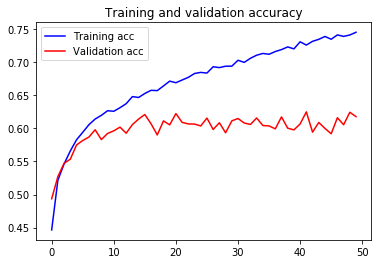

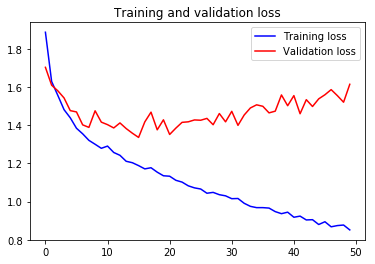

0.625
0.7453717870257038


In [49]:
#View results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

print max(val_acc)
print max(acc)

In [45]:
#Get Category names
file = ('/floyd/input/deep_fashion_images/Anno/list_category_cloth.txt')
f=open(file,"r")
categories = f.readlines()

#Given prediction integer, lookup category in string
def predictionCategoryLookup(pred):
    pred = int(pred)
    return categories[pred+1].rstrip()



In [67]:
#Find mislabeled articles, (predicted, actual)
incorrect_labels = {}
floydDir = ('/floyd/input/deep_fashion_images/')
# for file in test_labels[0]:
for i in range(100):
    file = test_labels[0][i]    
    path = pJoin(floydDir, file)
    img = importImage(path)
    img = np.expand_dims(img, axis=0)
    pred = model.predict_classes(img)
    prediction_label = predictionCategoryLookup(pred)
    actual_label = predictionCategoryLookup(catLookup(file))
    if prediction_label != actual_label:
        incorrect_labels[path] = (prediction_label, actual_label)
print incorrect_labels
# print pred
# print catLookup(file_name)

{'/floyd/input/deep_fashion_images/img/Young_Romance_Sweater/img_00000041.jpg': ('Blouse         1', 'Sweater        1'), '/floyd/input/deep_fashion_images/img/Boxy_Floral_Crochet_Top/img_00000015.jpg': ('Blouse         1', 'Top            1'), '/floyd/input/deep_fashion_images/img/Button-Front_Blazer/img_00000104.jpg': ('Jacket         1', 'Blazer         1'), '/floyd/input/deep_fashion_images/img/Crochet-Trimmed_Medallion_Print_Tank/img_00000021.jpg': ('Blouse         1', 'Tank           1'), '/floyd/input/deep_fashion_images/img/Abstract_Geo_Print_Blouse/img_00000037.jpg': ('Tee            1', 'Blouse         1'), '/floyd/input/deep_fashion_images/img/Bleached_Thermal_Top/img_00000017.jpg': ('Blouse         1', 'Top            1'), '/floyd/input/deep_fashion_images/img/Open-Knit_Tasseled_Cardigan/img_00000012.jpg': ('Blouse         1', 'Cardigan       1'), '/floyd/input/deep_fashion_images/img/Hooded_French_Terry_Dress/img_00000007.jpg': ('Jacket         1', 'Dress          3'), '/f

In [68]:
print incorrect_labels.values()

[('Blouse         1', 'Sweater        1'), ('Blouse         1', 'Top            1'), ('Jacket         1', 'Blazer         1'), ('Blouse         1', 'Tank           1'), ('Tee            1', 'Blouse         1'), ('Blouse         1', 'Top            1'), ('Blouse         1', 'Cardigan       1'), ('Jacket         1', 'Dress          3'), ('Shorts         2', 'Romper         3'), ('Romper         3', 'Dress          3'), ('Skirt          2', 'Cardigan       1'), ('Jeans          2', 'Shorts         2'), ('Sweater        1', 'Tee            1'), ('Blouse         1', 'Tee            1'), ('Romper         3', 'Blouse         1'), ('Jumpsuit       3', 'Romper         3'), ('Blouse         1', 'Cardigan       1'), ('Tee            1', 'Blouse         1'), ('Tee            1', 'Sweater        1'), ('Tee            1', 'Jumpsuit       3'), ('Tank           1', 'Jeans          2'), ('Shorts         2', 'Sweatshorts    2'), ('Blouse         1', 'Jacket         1'), ('Dress          3', 'Romper     

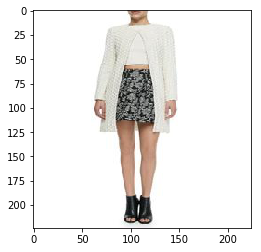

('Skirt          2', 'Cardigan       1')


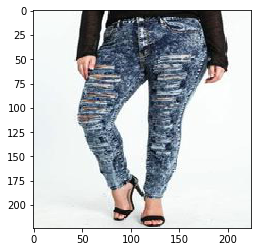

('Jeans          2', 'Shorts         2')


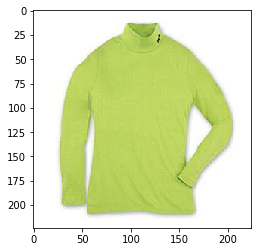

('Sweater        1', 'Tee            1')


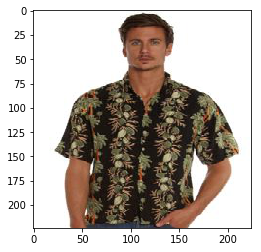

('Blouse         1', 'Tee            1')


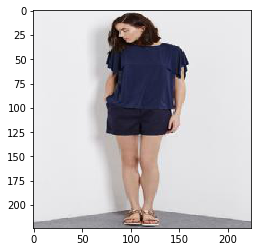

('Romper         3', 'Blouse         1')


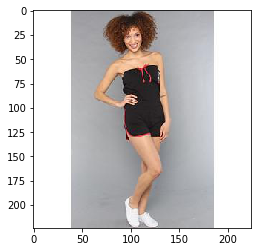

('Jumpsuit       3', 'Romper         3')


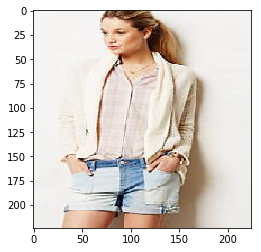

('Blouse         1', 'Cardigan       1')


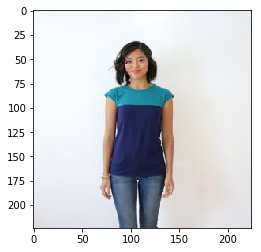

('Tee            1', 'Blouse         1')


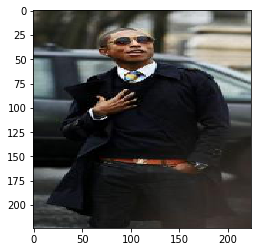

('Tee            1', 'Sweater        1')


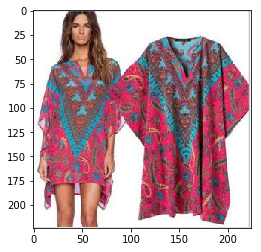

('Tee            1', 'Jumpsuit       3')


In [81]:
#Show a few images
for i in range(10):
    i = i+10
    image_path = incorrect_labels.keys()[i]
    image = importImage(image_path)
    plt.imshow(np.uint8(image))
    plt.show()
    print incorrect_labels.values()[i]


In [82]:
#Find correctly labeled articles
correct_labels = {}
floydDir = ('/floyd/input/deep_fashion_images/')
# for file in test_labels[0]:
for i in range(100):
    file = test_labels[0][i]    
    path = pJoin(floydDir, file)
    img = importImage(path)
    img = np.expand_dims(img, axis=0)
    pred = model.predict_classes(img)
    prediction_label = predictionCategoryLookup(pred)
    actual_label = predictionCategoryLookup(catLookup(file))
    if prediction_label == actual_label:
        correct_labels[path] = (prediction_label, actual_label)
print correct_labels

{'/floyd/input/deep_fashion_images/img/Glitter_Bodycon_Dress/img_00000068.jpg': ('Dress          3', 'Dress          3'), '/floyd/input/deep_fashion_images/img/Strapless_Woven_Romper/img_00000012.jpg': ('Romper         3', 'Romper         3'), '/floyd/input/deep_fashion_images/img/Loose-Knit_Longline_Cardigan/img_00000016.jpg': ('Cardigan       1', 'Cardigan       1'), '/floyd/input/deep_fashion_images/img/Everyday_Tank/img_00000041.jpg': ('Tank           1', 'Tank           1'), '/floyd/input/deep_fashion_images/img/Crochet-Paneled_Chiffon_Blouse/img_00000076.jpg': ('Blouse         1', 'Blouse         1'), '/floyd/input/deep_fashion_images/img/Collarless_Quilted_Moto_Jacket/img_00000025.jpg': ('Jacket         1', 'Jacket         1'), '/floyd/input/deep_fashion_images/img/Belted_Mandala_Print_Dress/img_00000029.jpg': ('Dress          3', 'Dress          3'), '/floyd/input/deep_fashion_images/img/Layered_Woven_Romper/img_00000013.jpg': ('Romper         3', 'Romper         3'), '/floyd/i

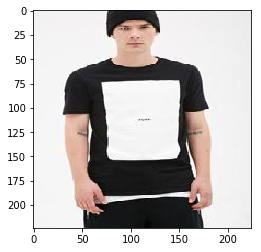

('Tee            1', 'Tee            1')


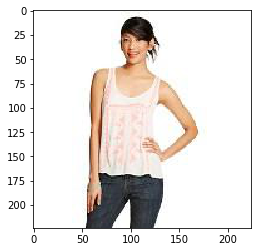

('Tank           1', 'Tank           1')


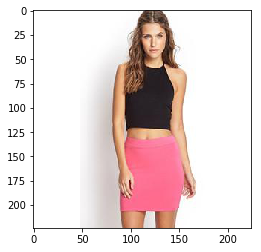

('Skirt          2', 'Skirt          2')


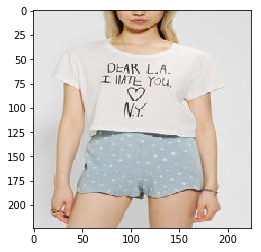

('Tee            1', 'Tee            1')


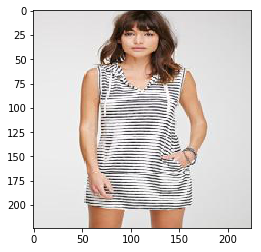

('Dress          3', 'Dress          3')


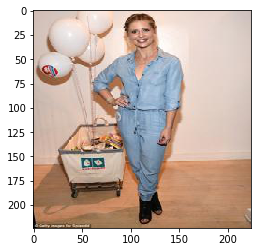

('Jumpsuit       3', 'Jumpsuit       3')


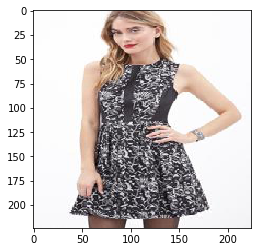

('Dress          3', 'Dress          3')


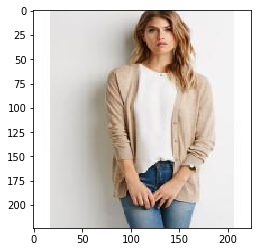

('Cardigan       1', 'Cardigan       1')


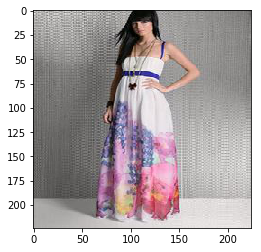

('Dress          3', 'Dress          3')


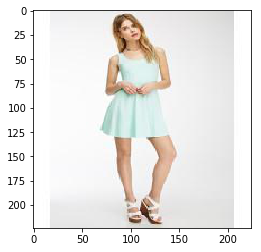

('Dress          3', 'Dress          3')


In [85]:
#Show a few images
for i in range(10):
    i=i+10
    image_path = correct_labels.keys()[i]
    image = importImage(image_path)
    plt.imshow(np.uint8(image))
    plt.show()
    print correct_labels.values()[i]

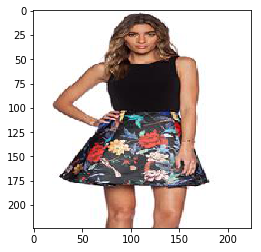

3.7820763e-14 Sweater        1
9.966078e-14 Romper         3
2.0552629e-11 Tank           1
2.4939363e-11 Blouse         1
1.5367672e-09 Tee            1
5.293432e-09 Top            1
1.9187311e-05 Skirt          2
0.9999808 Dress          3
41 Dress          3 0.9999808


In [64]:
#IN DEV: Find probability of article of clothing
floydDir = ('/floyd/input/deep_fashion_images/')
# for file in test_labels[0]:
file = test_labels[0][500]    
path = pJoin(floydDir, file)
img = importImage(path)
img = np.expand_dims(img, axis=0)
pred = model.predict_proba(img)

probs = []
for i in pred[0]:
    probs.append(i)
probs = np.array(probs)
bestChoice = np.argmax(probs)
probsIndices = probs.argsort()
top3indices=probsIndices[-8:]
img = importImage(path)
plt.imshow(np.uint8(img))
plt.show()
#Print class number, article of clthing + category type, and the probability
for i in top3indices:
    print probs[i], predictionCategoryLookup(i)
    
print bestChoice, predictionCategoryLookup(bestChoice), max(probs)